In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
torch.manual_seed(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Labels
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress,
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot


In [5]:
df_train = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
df_test = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')
df_train.sample(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
2873,0,0,0,0,0,0,0,0,0,0,...,86,85,75,0,0,0,0,0,0,0
44369,6,0,0,0,0,0,0,1,2,0,...,53,0,0,0,61,61,0,0,0,0
3431,0,0,0,1,0,0,0,0,63,156,...,190,127,72,25,26,0,1,0,0,0
18456,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20626,4,0,0,0,0,0,0,1,1,0,...,0,2,0,0,81,93,62,0,0,0


In [6]:
print(df_train.shape)
print(df_test.shape)

(60000, 785)
(10000, 785)


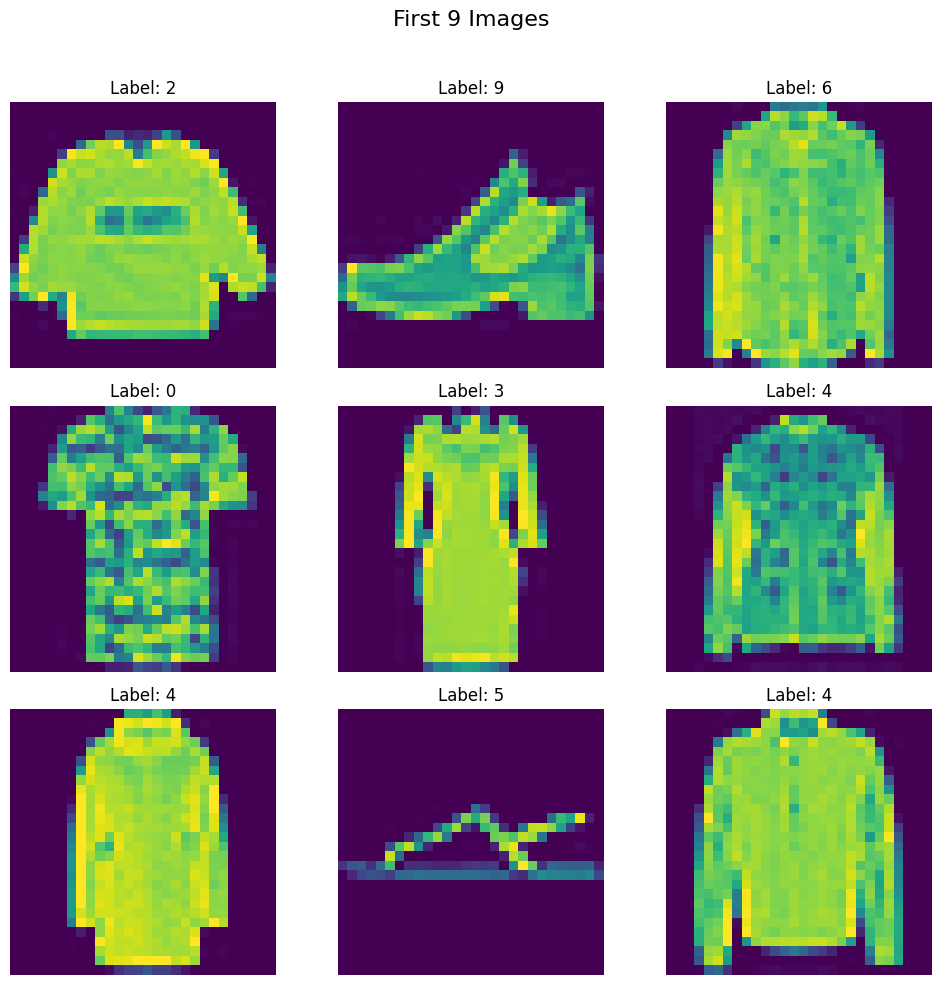

In [7]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("First 9 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df_train.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df_train.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [8]:
# split
x_train = df_train.iloc[:, 1:].values
y_train= df_train.iloc[:, 0].values

x_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [9]:
x_train.shape

(60000, 784)

In [10]:
# normalization
print(f"before: {x_train}")

x_train = x_train/255.0
x_test = x_test/255.0
print(f"After: {x_train}")

before: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
After: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
# def custom class for using dataset and dataloader libraries
class CustomDataset(Dataset):
    
    def __init__(self, features, labels): # load and convert/make necessary changes to the features in dataset
        self.features= torch.tensor(features, dtype=torch.float32)
        self.labels= torch.tensor(labels, dtype=torch.long)

    def __len__(self): # return num rows
        return len(self.features)

    def __getitem__(self, index): # return data point at specific index
        return self.features[index], self.labels[index]

In [12]:
train_dataset = CustomDataset(x_train, y_train)

In [13]:
train_dataset[0] # image normalized pixel values with label

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2431, 0.2392, 0.0824, 0.1137, 0.0902,
         0.2000, 0.5333, 0.2392, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [14]:
train_dataset.__len__()

60000

In [15]:
test_dataset = CustomDataset(x_test, y_test)

In [16]:
len(test_dataset)

10000

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=False)

In [18]:
train_loader

In [19]:
len(train_loader) # num batches; 32 * 1875 = 60,000

1875

In [20]:
# my neural network

class MyNN(nn.Module):

    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128), # input neurons: num of features (784), output neurons: 128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10) # 10 labels
        )

    def forward(self, x):
        return self.model(x)

In [21]:
# params
lr= 0.1
epochs= 100

In [22]:
# instantiate model
model= MyNN(x_train.shape[1])
model= model.to(device) # put model on gpu

# loss func
loss_type = nn.CrossEntropyLoss()

#optimiser
optimizer= optim.SGD(model.parameters(), lr=lr)

In [23]:
# training loop

for epoch in range(epochs):
    
    total_epoch_loss= 0
    
    for batch_features, batch_labels in train_loader:

        #move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        #forward pass
        outputs = model.forward(batch_features)

        # loss calculation
        loss= loss_type(outputs, batch_labels)

        # backprop
        optimizer.zero_grad()
        loss.backward()

        # update grads
        optimizer.step()

        # total loss
        total_epoch_loss += loss.item()   

    avg_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss}")

Epoch: 1, Loss: 0.6010189413030942
Epoch: 2, Loss: 0.4135076250910759
Epoch: 3, Loss: 0.37121313376426696
Epoch: 4, Loss: 0.3437591538945834
Epoch: 5, Loss: 0.32385402583877243
Epoch: 6, Loss: 0.3091171885728836
Epoch: 7, Loss: 0.2962389718155066
Epoch: 8, Loss: 0.28478200549980004
Epoch: 9, Loss: 0.27343885239958765
Epoch: 10, Loss: 0.26577090840637685
Epoch: 11, Loss: 0.25830729249715806
Epoch: 12, Loss: 0.25099953015943366
Epoch: 13, Loss: 0.24375854245920975
Epoch: 14, Loss: 0.23399951468805472
Epoch: 15, Loss: 0.23218018555541833
Epoch: 16, Loss: 0.22519357588986555
Epoch: 17, Loss: 0.22086197706957658
Epoch: 18, Loss: 0.21513471797307332
Epoch: 19, Loss: 0.21071677063380678
Epoch: 20, Loss: 0.205938256465892
Epoch: 21, Loss: 0.20132937553326288
Epoch: 22, Loss: 0.19747952504952748
Epoch: 23, Loss: 0.1947750591923793
Epoch: 24, Loss: 0.18993149445156257
Epoch: 25, Loss: 0.18798903200775385
Epoch: 26, Loss: 0.18390918584913016
Epoch: 27, Loss: 0.18106138862520457
Epoch: 28, Loss: 0

In [24]:
# set model to eval mode (for cases like dropout, batch normalization)
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [25]:
# eval code

total= 0
correct= 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:

        # move to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs= model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(correct / total)

0.8811
